In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
import torch.functional as F
import numpy as np
import pandas as pd
import time
import random
from tqdm import tqdm_notebook

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data prep

In [79]:
import selfies as sf
data = pd.read_csv('./GRU_data/selfies.csv', header=None, names=['selfies'])
alphabet = sf.get_alphabet_from_selfies(data.selfies)
alphabet.add("[nop]") # [nop] is a special padding symbol
alphabet.add("[start]")
alphabet.add("[end]")
alphabet = list(sorted(alphabet))
pad_to_len = max(sf.len_selfies(s) for s in data.selfies) + 5
print("Pad to len:", pad_to_len)
symbol_to_idx = {s: i for i, s in enumerate(alphabet)}
idx2char = {i: s for i, s in enumerate(alphabet)}

Pad to len: 114


In [80]:
len(alphabet)

42

In [81]:
from torch.utils.data import Dataset, DataLoader

class GRUDataset(Dataset):
    def __init__(self, smiles_fp, selfies, vectorizer):
        self.smiles_fp = pd.read_csv(smiles_fp, sep=',', nrows=10000)
        self.selfies = pd.read_csv(selfies, nrows=10000)
        self.X = self.prepare_X(self.smiles_fp)
        self.X = np.array([self.reconstruct_fp(fp) for fp in self.X])
        self.y = self.prepare_y(self.selfies)
    def __len__(self):
        return len(self.smiles_fp)
    def __getitem__(self, idx):
        raw_selfie = self.y[idx][0]
        vectorized_selfie = vectorizer.vectorize(raw_selfie)
        return torch.from_numpy(self.X[idx]).float(), torch.from_numpy(vectorized_selfie).float()

    @staticmethod
    def prepare_X(smiles_fp):
        fps = smiles_fp.fps.apply(eval).apply(lambda x: np.array(x, dtype=int))
        return fps
    @staticmethod
    def prepare_y(selfies):
        return selfies.values
    @staticmethod
    def reconstruct_fp(fp, length=4860):
        fp_rec = np.zeros(length)
        fp_rec[fp] = 1
        return fp_rec

In [82]:
import re
class SELFIESVectorizer:
    def __init__(self, alphabet, pad_to_len):
        self.alphabet = alphabet
        self.pad_to_len = pad_to_len
        self.char2idx = {s: i for i, s in enumerate(alphabet)}
        self.idx2char = {i: s for i, s in enumerate(alphabet)}
    def vectorize(self, selfie):
        ''' Vectorize a list of SMILES strings to a numpy array of shape (len(smiles), embed, len(charset))'''
        X = np.zeros((self.pad_to_len, len(self.alphabet)))
        splited = ['[start]'] + self.split_selfi(selfie) + ['[end]'] + ['[nop]'] * (self.pad_to_len - len(self.split_selfi(selfie)) - 2)
        for i, char in enumerate(splited):
            X[i, self.char2idx[char]] = 1
        return X
    def devectorize(self, ohe):
        ''' Devectorize a numpy array of shape (len(smiles), embed, len(charset)) to a list of SMILES strings'''
        selfie_str = ''
        for j in range(self.pad_to_len):
            char = self.idx2char[np.argmax(ohe[j])]
            if char == '[start]':
                continue
            elif char == '[end]':
                break
            else:
                selfie_str += char
        return selfie_str

    def split_selfi(self, selfie):
        pattern = r'(\[[^\[\]]*\])'
        return re.findall(pattern, selfie)

In [83]:
vectorizer = SELFIESVectorizer(alphabet, pad_to_len)
dataset = GRUDataset('GRU_data/chembl_klek.csv', 'GRU_data/selfies.csv', vectorizer)

In [84]:
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [85]:
batch_size = 64
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, drop_last=True)
next(iter(train_loader))[0].shape

torch.Size([64, 4860])

# NN architecture

In [86]:
import random

class EncoderNet(nn.Module):
    def __init__(self, fp_size, encoding_size):
        super(EncoderNet, self).__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(fp_size, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, encoding_size)

    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.relu(self.fc4(out))
        out = self.relu(self.fc5(out))
        return out

class DecoderNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, drop_prob, tracher_forcing):
        super(DecoderNet, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, dropout=drop_prob, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=2)
        self.max_len = vectorizer.pad_to_len

    def forward(self, encoded):
        batch_size = encoded.size(0)
        hidden = self.init_hidden(encoded)
        start_vector = vectorizer.vectorize('[start]')
        start_vector = torch.from_numpy(start_vector).float().to(device)
        start_vector = start_vector.unsqueeze(0)
        start_vector = start_vector.repeat(batch_size, 1, 1)
        print(f'Start vector size: {start_vector.size()}')
        decoded, hidden = self.gru(start_vector, hidden)
        decoded = self.fc(decoded)
        return decoded

    def init_hidden(self, encoded):
        return encoded.unsqueeze(0).repeat(self.num_layers, 1, 1).to(device)
    
class Autoencoder(nn.Module):
    def __init__(self, input_size=4860, encoding_size=128, decoding_size=128, output_size=42, num_layers=2, 
                 drop_prob=0.2, teacher_forcing=0.5):
        super(Autoencoder, self).__init__()
        self.encoder = EncoderNet(input_size, encoding_size)
        self.decoder = DecoderNet(output_size, decoding_size, output_size, num_layers, drop_prob, teacher_forcing)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [88]:
encoder = EncoderNet(4860, 128).to(device)
decoder = DecoderNet(42, 128, 42, 2, 0.1, 0.5).to(device)
test_batch = next(iter(train_loader))[0].to(device)

In [89]:
print(f'Test batch shape: {test_batch.shape}')
encoded = encoder(test_batch)
print(f'Encoded shape: {encoded.shape}')
print(f'Encoded: {encoded[0, :]}')

Test batch shape: torch.Size([64, 4860])
Encoded shape: torch.Size([64, 128])
Encoded: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0362, 0.0000, 0.0000, 0.0425, 0.0000,
        0.0656, 0.0830, 0.0339, 0.0000, 0.0000, 0.0000, 0.0504, 0.0000, 0.0000,
        0.0366, 0.0234, 0.0549, 0.0240, 0.0000, 0.0412, 0.0000, 0.0415, 0.0000,
        0.0000, 0.0000, 0.0381, 0.0000, 0.0000, 0.0000, 0.0406, 0.0482, 0.0220,
        0.0589, 0.0000, 0.0470, 0.0000, 0.0633, 0.0000, 0.0000, 0.0106, 0.0401,
        0.0000, 0.0576, 0.0000, 0.0490, 0.0466, 0.0066, 0.0000, 0.0187, 0.0490,
        0.0000, 0.0000, 0.0301, 0.0717, 0.0000, 0.0000, 0.0604, 0.0000, 0.0184,
        0.0000, 0.0000, 0.0367, 0.0623, 0.0000, 0.0089, 0.0144, 0.0000, 0.0341,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0232, 0.0177, 0.0000, 0.0074, 0.0183,
        0.0819, 0.0148, 0.0455, 0.0000, 0.0517, 0.0714, 0.0506, 0.0000, 0.0390,
        0.0279, 0.0000, 0.0569, 0.0000, 0.0000, 0.0000, 0.0527, 0.0000, 0.0391,
        0.0155, 0.0000, 0.0143, 0

In [90]:
decoded = decoder(encoded)
print(f'Decoded shape: {decoded.shape}')

Start vector size: torch.Size([64, 114, 42])
Decoded shape: torch.Size([64, 114, 42])


In [91]:
model = Autoencoder(4860, 300, 300, 42, 2, 0.0).to(device)

with torch.no_grad():
    encoded, decoded = model(test_batch)
    print(f'Encoded shape: {encoded.shape}')
    print(f'Decoded shape: {decoded.shape}')

Start vector size: torch.Size([64, 114, 42])
Encoded shape: torch.Size([64, 300])
Decoded shape: torch.Size([64, 114, 42])


# Training

In [92]:
def train(autoencoder, dataloader, num_epochs=10, device=device):
    
    learning_rate = 0.001
    teacher_forcing_ratio = 0.5

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

    # Training loop
    print('Training started')
    for epoch in range(num_epochs):
        start_time = time.time()
        avg_loss = 0.
        counter = 0
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            encoded, decoded = autoencoder(x)
            loss = criterion(decoded, y)
            loss.backward()
            optimizer.step()
            
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
        
    return autoencoder

In [93]:
input_size = 4860
encoding_size = 128
decoding_size = 128
output_size = 42
num_layers = 2
teacher_forcing = 0.5
drop_prob = 0.2

model = Autoencoder(input_size=input_size, encoding_size=encoding_size, decoding_size=decoding_size,
                    output_size=output_size, num_layers=num_layers, drop_prob=drop_prob,
                    teacher_forcing=teacher_forcing).to(device)

In [137]:
model = train(autoencoder=model, dataloader=train_loader, num_epochs=200)

Training started
Epoch [1/200], Loss: 11.2717
Epoch [2/200], Loss: 11.2190
Epoch [3/200], Loss: 11.2220
Epoch [4/200], Loss: 11.2089
Epoch [5/200], Loss: 11.2127
Epoch [6/200], Loss: 11.1438
Epoch [7/200], Loss: 11.2166
Epoch [8/200], Loss: 11.2059
Epoch [9/200], Loss: 11.1810
Epoch [10/200], Loss: 11.2048
Epoch [11/200], Loss: 11.1278
Epoch [12/200], Loss: 11.1394
Epoch [13/200], Loss: 11.1911
Epoch [14/200], Loss: 11.1235
Epoch [15/200], Loss: 11.1235
Epoch [16/200], Loss: 11.1210
Epoch [17/200], Loss: 11.1605
Epoch [18/200], Loss: 11.0968
Epoch [19/200], Loss: 11.1586
Epoch [20/200], Loss: 11.1293
Epoch [21/200], Loss: 11.1211
Epoch [22/200], Loss: 11.1406
Epoch [23/200], Loss: 11.1354
Epoch [24/200], Loss: 11.1209
Epoch [25/200], Loss: 11.1470
Epoch [26/200], Loss: 11.1504
Epoch [27/200], Loss: 11.0867
Epoch [28/200], Loss: 11.0608
Epoch [29/200], Loss: 11.0918
Epoch [30/200], Loss: 11.0747
Epoch [31/200], Loss: 11.1075
Epoch [32/200], Loss: 11.0803
Epoch [33/200], Loss: 11.1330
Ep

In [57]:
# save model just in case
torch.save(model.state_dict(), './GRU_data/model_200e.pth')

In [36]:
# Hubert jakby co, to możesz wczytać model z pliku, 
# żeby nie trzeba było czekać 200 epok
loaded_model = Autoencoder(4860, 300, 300, 42, 2, 0.0).to(device)
loaded_model.load_state_dict(torch.load('./GRU_data/model_200e.pth', map_location=torch.device(device)))

<All keys matched successfully>

In [94]:
x, y = next(iter(test_loader))
x = x.to(device)
x.size()

torch.Size([64, 4860])

In [95]:
encoded, decoded = loaded_model(x)

Start vector size: torch.Size([64, 114, 42])


# GRU output to SELFIES

In [96]:
decoded_indices = torch.argmax(decoded.cpu(), dim=2)
decoded_indices = decoded_indices.numpy()

In [97]:
# set largers value to 1 and others to 0
decoded_indices = torch.argmax(decoded.cpu(), dim=2)
decoded_indices = decoded_indices.numpy()
selfies_out = []
for i, original in zip(decoded_indices, y):
    vectorized = []
    #print(f'Decoded: {i}')
    #convert to one-hot
    for number in i:
        v = np.zeros(42)
        v[number] = 1
        vectorized.append(v)
    selfies_out.append(vectorizer.devectorize(vectorized))
    print(f'Original: {vectorizer.devectorize(original.cpu().numpy())} \n')
    print(f'Decoded:  {vectorizer.devectorize(vectorized)}')
    print('------------------')

Original: [C][=C][C][=C][C][Branch1][C][Cl][=C][C][Branch1][C][Cl][=C][Ring1][Branch2][C][N][C][=Branch1][C][=O][C][C][O][C][=N][C][=C][C][=C][Ring1][=Branch1][Ring1][=Branch2] 

Decoded:  [O-1][=N+1][C@@][P][P][=S][C@@][P][C@@][\O][C@@][C@@][/O][=N+1][C@@][\O][\O][\O][/O][C@@][\O][=N+1][/O][/O][/O][/O][/O][C@@][C@@][C@@][=N+1][=N+1][=N+1][=N+1][C@@][C@@]
------------------
Original: [C][C][Branch1][C][C][N][Branch1][C][C][C][C][=C][Branch1][=Branch1][C][Branch1][C][N][=O][N][=C][N][Ring1][Branch2][C][C][C][Branch1][Ring2][C][Ring1][Ring2][C][=C][C][Branch1][C][F][=C][Branch1][O][C][#C][C][Branch1][C][C][Branch1][C][C][O][C][=C][Ring1][=N][Ring2][Ring1][Ring1] 

Decoded:  [=S][NH1][P][P][\N][\N][P][\N][\O][\N][\O][\N][\O][\O][\N][\O][\N][\N][\N][\N][\N][\N][\N][\N][\N][\N][\N][\N][\N][\N][\N][\N][\N][\N][\N][\N][\N][\N][P][\N][\N][P][P][P][P][P][P][P][P][P][P][P][P][P][=Ring2][=Ring2][P][P][P][P][P][P][P][P][P][P][P][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]

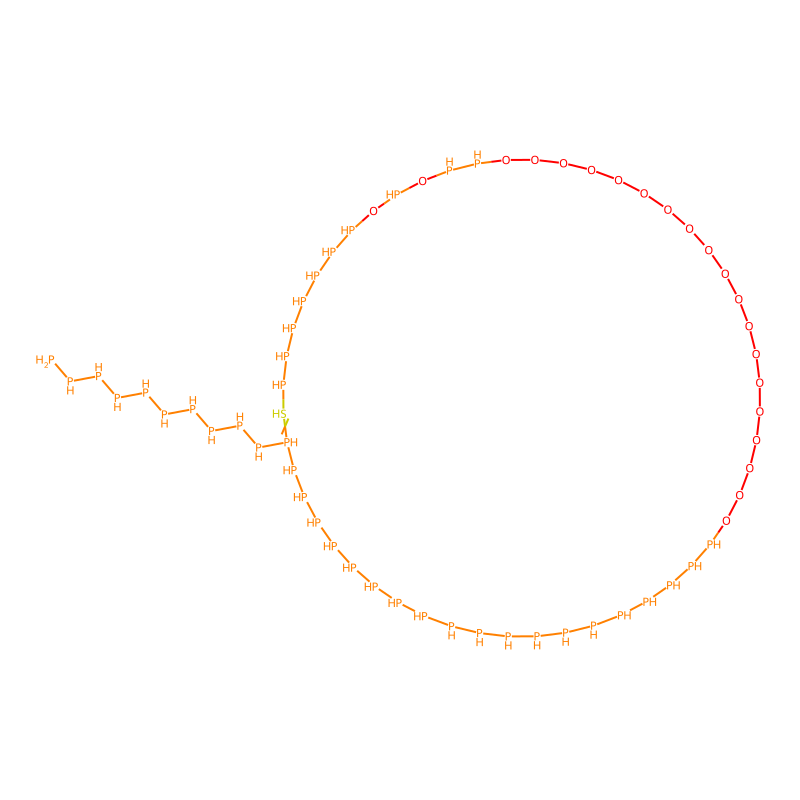

In [60]:
from rdkit import Chem
from rdkit.Chem import Draw

smiles = []
for selfie in selfies_out:
    smile = sf.decoder(selfie, attribute=False)
    smiles.append(smile)

ms = []
for smile in smiles:
    ms.append(Chem.MolFromSmiles(smile))
Draw.MolToImage(ms[15], size=(800, 800), kekulize=True)